# StreetViewGAN - Translating Between Maps and Real World Images

In [49]:
import os
import gradio as gr
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image as PILImage
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import InterpolationMode
from torchvision.transforms import ToPILImage
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import tarfile
import urllib.request
%matplotlib inline

## Download the Dataset

In [2]:
dataset_name = "maps"
_URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"

# Download and extract the dataset
def download_and_extract(url, download_path):
    if not download_path.exists():
        print(f"Downloading {url}...")
        tar_path, _ = urllib.request.urlretrieve(url)
        print(f"Extracting to {download_path}...")
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=download_path.parent)
    else:
        print(f"{dataset_name} already downloaded.")

# Set paths
base_path = pathlib.Path('./data')
download_path = base_path / dataset_name
base_path.mkdir(exist_ok=True)

download_and_extract(_URL, download_path)

# Now dataset is available at:
print("Dataset path:", download_path)

Extracting to data/maps...
Dataset path: data/maps


## Data Preprocessing

In [25]:
data_transform  = T.Compose([
    T.Resize(286, interpolation=InterpolationMode.BICUBIC),     # 256→286
    T.RandomCrop((256, 256)),                       # crop height = 256, width = 256
    T.RandomHorizontalFlip(p=0.5),                  # mirror left ↔ right
    T.ToTensor(),                                   # [0,255] → [0,1]
    T.Normalize((0.5,)*3, (0.5,)*3)                 # →[−1,1]
])

In [50]:
class Pix2PixDataset(Dataset):
    def __init__(self, root, mode='train', transform=None):
        self.root = pathlib.Path(root) / mode
        self.files = sorted(self.root.glob("*.jpg"))
        self.transform = transform

    def __len__(self): 
        return len(self.files)

    def __getitem__(self, idx):
        img = PILImage.open(self.files[idx]).convert("RGB")
        w, h = img.size
        w2 = w // 2

        # left = real, right = street
        real_img   = img.crop((0, 0, w2, h))
        street_img = img.crop((w2, 0, w,  h))

        if self.transform:
            street_img = self.transform(street_img)
            real_img   = self.transform(real_img)

        return street_img, real_img

In [51]:
# Build the loaders
train_ds = Pix2PixDataset('./data/maps', mode='train', transform=data_transform)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)

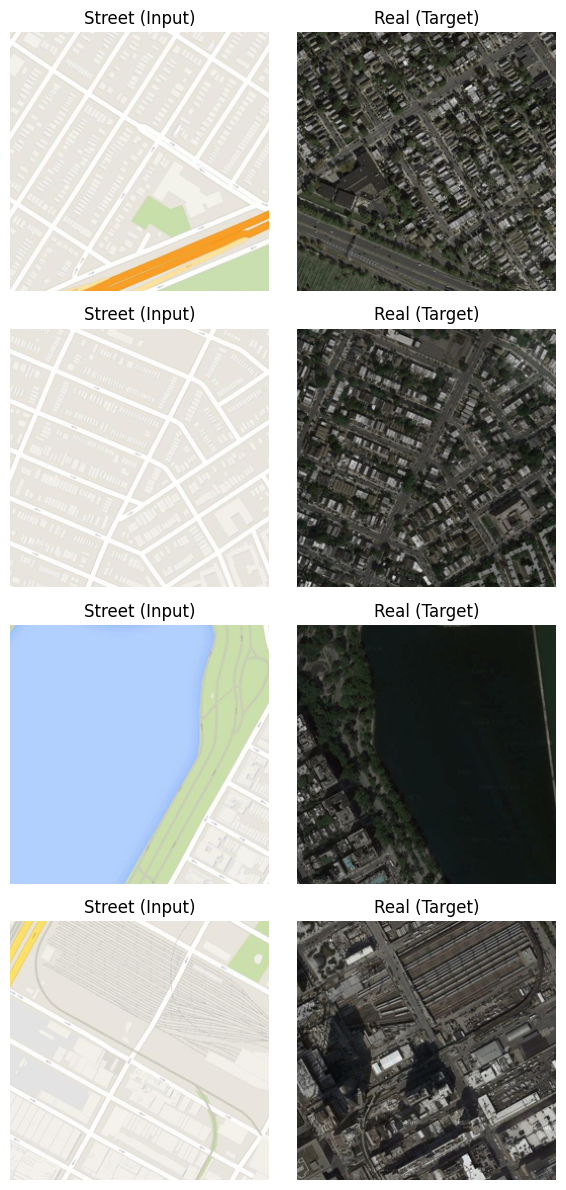

In [52]:
from PIL import Image

fig, axes = plt.subplots(4, 2, figsize=(6, 12))

for i, (street, real) in enumerate(train_dl):
    if i == 4: break

    # denormalize back to [0,1]
    st = street * 0.5 + 0.5
    re = real   * 0.5 + 0.5

    axes[i, 0].imshow(st[0].permute(1, 2, 0))
    axes[i, 0].set_title("Street (Input)")
    axes[i, 1].imshow(re[0].permute(1, 2, 0))
    axes[i, 1].set_title("Real (Target)")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

## Discriminator Network

In [53]:
class Pix2PixDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base_features=64):
        super().__init__()
        # Since we concatwnate two images, the first conv sees in_channels*2
        self.model = nn.Sequential(
        # → (in_channels*2) x 256 x 256
        nn.Conv2d(in_channels * 2, base_features, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(base_features),
        nn.LeakyReLU(0.2, inplace=True),
        # → base_features x 128 x 128

        nn.Conv2d(base_features, base_features*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(base_features*2),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*2) x 64 x 64

        nn.Conv2d(base_features*2, base_features*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(base_features*4),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*4) x 32 x 32

        nn.ZeroPad2d(1),  
        # → (base_features*4) x 34 x 34

        nn.Conv2d(base_features*4, base_features*8, kernel_size=4, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(base_features*8),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*8) x 32 x 32

        nn.ZeroPad2d(1),  
        # → (base_features*8) x 34 x 34

        # final “patch” conv; produces a 31×31 score map
        nn.Conv2d(base_features*8, 1, kernel_size=4, stride=1, padding=1, bias=False),
        # → 1 x 31 x 31
        )

    def forward(self, real_input, real_target):
        x = torch.cat([real_input, real_target], dim = 1)  
        return self.model(x)

## Generator Network

In [54]:
class Pix2PixGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        # --- ENCODER (downsampling) ---
        # 256→128
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 128→64
        self.enc2 = nn.Sequential(
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 64→32
        self.enc3 = nn.Sequential(
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 32→16
        self.enc4 = nn.Sequential(
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 16→8
        self.enc5 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 8→4
        self.enc6 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 4→2
        self.enc7 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 2→1  (bottleneck)
        self.enc8 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # --- DECODER (upsampling) ---
        # 1→2
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        # 2→4 (cat → 16 channels in)
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        # 4→8
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        # 8→16
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.ReLU(inplace=True)
        )
        # 16→32 (cat 16+16→32 channels)
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*4),
            nn.ReLU(inplace=True)
        )
        # 32→64
        self.dec6 = nn.Sequential(
            nn.ConvTranspose2d(features*4*2, features*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*2),
            nn.ReLU(inplace=True)
        )
        # 64→128
        self.dec7 = nn.Sequential(
            nn.ConvTranspose2d(features*2*2, features,   kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

        # final 128→256 & 3 channels
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)   # 256→128
        e2 = self.enc2(e1)  # 128→64
        e3 = self.enc3(e2)  # 64→32
        e4 = self.enc4(e3)  # 32→16
        e5 = self.enc5(e4)  # 16→8
        e6 = self.enc6(e5)  # 8→4
        e7 = self.enc7(e6)  # 4→2
        e8 = self.enc8(e7)  # 2→1  (bottleneck)

        # --- decode & concat skips ---
        d1 = self.dec1(e8); d1 = torch.cat([d1, e7], dim=1)  # 1→2
        d2 = self.dec2(d1); d2 = torch.cat([d2, e6], dim=1)  # 2→4
        d3 = self.dec3(d2); d3 = torch.cat([d3, e5], dim=1)  # 4→8
        d4 = self.dec4(d3); d4 = torch.cat([d4, e4], dim=1)  # 8→16
        d5 = self.dec5(d4); d5 = torch.cat([d5, e3], dim=1)  # 16→32
        d6 = self.dec6(d5); d6 = torch.cat([d6, e2], dim=1)  # 32→64
        d7 = self.dec7(d6); d7 = torch.cat([d7, e1], dim=1)  # 64→128

        return self.final(d7) # → 256×256×3

## Discriminator Training

In [55]:
def train_discriminator(discriminator, generator, real_images, map_images, opt_d):
    discriminator.train()
    
    # Clear discriminator gradients
    opt_d.zero_grad()

    # ——— Real pairs ———
    # D(map, real) should predict “real” → target=1
    real_preds = discriminator(map_images, real_images)
    real_targets = torch.ones_like(real_preds)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = real_preds.mean().item()

    # ——— Fake pairs ———
    # Generate fake images
    # G(map) → fake; detach so G’s grad isn’t updated here
    fake_images = generator(map_images).detach()
    fake_preds = discriminator(map_images, fake_images)
    fake_targets = torch.zeros_like(fake_preds)
    fake_loss    = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score   = fake_preds.mean().item()


    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

## Generator Training

In [56]:
def train_generator(discriminator, generator, map_images, real_images, opt_g, lambda_L1 = 100):
    generator.train()
    
    # Clear generator gradients
    opt_g.zero_grad()

    # 1) Adversarial loss
    # Generate fake images
    fake_images = generator(map_images)

    # Try to fool the discriminator
    preds = discriminator(map_images, fake_images)
    targets = torch.ones_like(preds)
    adv_loss = F.binary_cross_entropy(preds, targets)

    # 2) L1 reconstruction loss
    l1_loss = F.l1_loss(fake_images, real_images)

    total_loss = adv_loss + (lambda_L1 * l1_loss)

    # Update generator weights
    total_loss.backward()
    opt_g.step()

    return total_loss.item(), adv_loss.item(), l1_loss.item()

In [57]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

## Saving Generated Samples

In [58]:
def save_samples(index, map_batch, generator, denorm, show=True):
    generator.eval()
    with torch.no_grad():
        fake = generator(map_batch)         

    # Denormalize into [0,1] for saving/viewing
    fake = denorm(fake)

    fname = f'generated-images-{index:04d}.png'
    save_image(fake, os.path.join(sample_dir, fname), nrow=8)
    print('Saving', fname)

    if show:
        grid = make_grid(fake.cpu(), nrow=8)   # shape (3, H, W)
        plt.figure(figsize=(8,8))
        plt.axis('off')
        plt.imshow(grid.permute(1,2,0)) # H×W×3
        plt.show()

## Full Training Loop

In [59]:
# Denormalize from [-1,1] back to [0,1]
def denorm(imgs):
    return imgs * 0.5 + 0.5

In [60]:
def fit(
    discriminator: nn.Module,
    generator:     nn.Module,
    train_dl,
    fixed_maps,           # a batch of map images, e.g. next(iter(val_dl))
    denorm,               # function mapping [-1,1]→[0,1]
    device = None,
    epochs = 200,
    lr = 2e-4,
    start_idx = 1
):
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))


    for epoch in range(start_idx, start_idx + epochs):
        sum_d = sum_g = 0.0
        sum_real_s = sum_fake_s = 0.0
        n = 0

        for maps, reals in tqdm(train_dl, desc=f"Epoch {epoch}/{start_idx+epochs-1}"):
            # — Train D —
            d_loss, real_s, fake_s = train_discriminator(
                discriminator, generator,
                reals, maps,
                opt_d
            )

            # — Train G —
            g_loss, adv_loss, l1_loss = train_generator(
                discriminator, generator,
                maps, reals,
                opt_g
            )

            sum_d       += d_loss
            sum_g       += g_loss
            sum_real_s  += real_s
            sum_fake_s  += fake_s
            n           += 1

        # Averages
        avg_d = sum_d / n
        avg_g = sum_g / n
        avg_real = sum_real_s / n
        avg_fake = sum_fake_s / n

        # Record losses & scores
        losses_d.append(avg_d)
        losses_g.append(avg_g)
        real_scores.append(avg_real)
        fake_scores.append(avg_fake)

        # Log losses & scores (last batch)
        print(
            f"Epoch [{epoch}]  "
            f"loss_g: {avg_g:.4f}, loss_d: {avg_d:.4f}, "
            f"real_score: {avg_real:.4f}, fake_score: {avg_fake:.4f}"
        )

        # Save generated images
        save_samples(epoch, fixed_maps, generator, denorm, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [61]:
discriminator = Pix2PixDiscriminator()
generator     = Pix2PixGenerator()
fixed_maps, _ = next(iter(train_dl))
lr = 0.0002
epochs = 200

history = fit(
    discriminator=discriminator,
    generator=generator,
    train_dl=train_dl,
    fixed_maps=fixed_maps,
    denorm=denorm,
    device=None,  
    epochs=200,
    lr=2e-4,
    start_idx=1
)

losses_g, losses_d, real_scores, fake_scores = history

Epoch 1/200:   0%|          | 0/1096 [00:00<?, ?it/s]


RuntimeError: all elements of input should be between 0 and 1

## Checkpointing


In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th, 10th, 50th, 100th, 150th, and 200th epochs of training.

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0050.png')

In [ ]:
Image('./generated/generated-images-0100.png')

In [ ]:
Image('./generated/generated-images-0150.png')

In [ ]:
Image('./generated/generated-images-0200.png')

## Plotting Loss of Generator & Discriminator

In [ ]:
epochs_range = list(range(1, len(losses_d) + 1))

In [ ]:
plt.clf()
plt.plot(epochs_range, losses_d, label="Discriminator")
plt.plot(epochs_range, losses_g, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Plotting Real & Fake Scores

In [ ]:
plt.clf()
plt.plot(epochs_range, real_scores, label="Real Score")
plt.plot(epochs_range, fake_scores, label="Fake Score")
plt.xlabel("Epoch")
plt.ylabel("Scores")
plt.title("Real vs Fake Scores per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Generating New Images

In [ ]:
# Building a validation loader
val_ds  = Pix2PixDataset('./data/maps', mode='val', transform=data_transform)
val_dl  = DataLoader(val_ds, batch_size=5, shuffle=True, num_workers=2)

In [ ]:
generator = Pix2PixGenerator()
generator.load_state_dict(torch.load('G.pth'))
generator.eval()

# Sampling from val_dl
maps_batch, _ = next(iter(val_dl))
fake_batch = generator(maps_batch)
fake_batch = denorm(fake_batch)

In [ ]:
# Display Images
grid = make_grid(fake_batch, nrow=5).permute(1,2,0).squeeze()
plt.figure(figsize=(25,3), dpi=100)
plt.axis('off')
plt.imshow(grid, cmap='gray', interpolation='nearest')
plt.show()

## User Interface

In [ ]:
# Wrapper to run your model end-to-end
def translate(map_img: Image.Image) -> Image.Image:
    # map_img is a PIL image; run the same transform you use in training
    x = data_transform(map_img).unsqueeze(0)  # 1×3×256×256
    with torch.no_grad():
        fake = generator(x)   # 1×3×256×256
    fake = denorm(fake[0]).clamp(0,1)   # back to [0,1]
    return ToPILImage()(fake)  # PIL for display

In [ ]:
iface = gr.Interface(
    fn=translate,
    inputs=gr.Image(type="pil", label="Input Map"),
    outputs=gr.Image(type="pil", label="Generated View"),
    title="StreetViewGAN",
    description="Upload a map; get the generated real-world view."
)

In [ ]:
# Launch
iface.launch()